# **Graph Workflows**

## **What's Covered?**
1. Sequential Graph
2. Conditional Graph
3. Conditional Looping Graph

## **Sequential Graph**

In [1]:
# Step 1: Defining a State
from typing import TypedDict, List

# Define a typed state
class AgentState(TypedDict):
    name: str
    values: List[int]
    response: str

In [2]:
# Step 2: Defining graph nodes

def first_node(state: AgentState) -> AgentState:
    """This function greets the user."""
    state['response'] = f"Hi {state['name']}"
    return state

def second_node(state: AgentState) -> AgentState:
    """This function takes a list and return the sum of all the values."""
    state['response'] = state['response'] + f"Sum of input list is {sum(state['values'])}."
    return state

In [3]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph

graph = StateGraph(AgentState)

graph.add_node("1st_node", first_node)
graph.add_node("2nd_node", second_node)

graph.set_entry_point("1st_node")
graph.add_edge("1st_node", "2nd_node")
graph.set_finish_point("2nd_node")

/Users/kanavbansal/Developer/.env_jupyter/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Step 4: Compile the graph

app = graph.compile()

app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9]})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'response': 'Hi ThatAIGuySum of input list is 15.'}

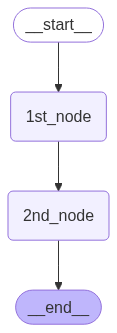

In [5]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## **Conditional Graph**

In [6]:
# Step 1: Defining a State
from typing import TypedDict, List

# Define a typed state
class AgentState(TypedDict):
    name: str
    values: List[int]
    operation: str
    response: str

In [16]:
# Step 2: Defining graph nodes
from functools import reduce

def greet_node(state: AgentState) -> AgentState:
    """This function greets the user."""
    state['response'] = f"Hi {state['name']}"
    return state

def sum_node(state: AgentState) -> AgentState:
    """This function takes a list and return the sum of all the values."""
    state['response'] = state['response'] + f"Sum of input list is {sum(state['values'])}."
    return state

def prod_node(state: AgentState) -> AgentState:
    """This function takes a list and return the product of all the values."""
    state['response'] = state['response'] + f"Product of input list is {reduce(lambda x,y : x*y, state['values'])}."
    return state

def decision_node(state: AgentState) -> AgentState:
    "This function decides the next node in the graph"
    if state['operation'] == "+":
        return "addition_operation"
    elif state['operation'] == "*":
        return "product_operation"

In [17]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("greeter", greet_node)
graph.add_node("add", sum_node)
graph.add_node("product", prod_node)
graph.add_node("router", lambda state:state) # Passthrough

graph.add_edge(START, "greeter")
graph.add_edge("greeter", "router")
graph.add_conditional_edges(
    "router",
    decision_node,
    {
        "addition_operation": "add",
        "product_operation": "product"
    }
)
graph.add_edge("add", END)
graph.add_edge("product", END)

In [19]:
# Step 4: Compile the graph

app = graph.compile()

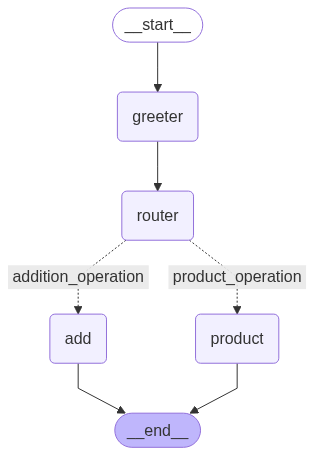

In [20]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9], "operation": "*"})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'operation': '*',
 'response': 'Hi ThatAIGuyProduct of input list is 0.'}

In [22]:
app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9], "operation": "+"})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'operation': '+',
 'response': 'Hi ThatAIGuySum of input list is 15.'}

## **Conditional Looping Graph**

In [23]:
from typing import TypedDict

class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int

In [29]:
import random

def greeting_node(state: AgentState) -> AgentState:
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, {state['name']}"
    state["counter"] = 0 

    return state

def random_node(state: AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop


In [30]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random",  
        "exit": END          
    }
)

graph.set_entry_point("greeting")

app = graph.compile()


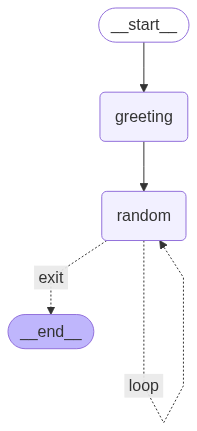

In [31]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
app.invoke({"name":"ThatAIGuy", "number":[], "counter":-100})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, ThatAIGuy', 'number': [6, 1, 6, 10, 0], 'counter': 5}